In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split


In [44]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [45]:
df.shape

(4026, 7)

In [46]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [48]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [49]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [50]:
y=normalized_df["Period (P)"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

In [52]:
from sklearn.model_selection import KFold,cross_validate
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplg

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
param_grid_simple={'n_estimators':hp.quniform('n_estimators',800,1500,50)
                   ,'max_depth':hp.quniform('max_depth',3,10,1)
                   ,'min_samples_leaf':hp.quniform('min_samples_leaf',2,20,2),
                   'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
                  }


In [55]:
def hyperopt_objective(params):
    model=GradientBoostingRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,min_samples_leaf=int(params['min_samples_leaf'])
              ,learning_rate=params['learning_rate']                     
              ,random_state=99)
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))

In [56]:
def param_hyperopt(max_evals=100):
     trials=Trials()
    
    early_stop_fn=no_progress_loss(100) 
    
    params_best=fmin(hyperopt_objective 
                     ,space=param_grid_simple 
                     ,algo=tpe.suggest 
                     ,max_evals=max_evals 
                     ,trials=trials 
                     ,early_stop_fn=early_stop_fn 
                    )
    
    print('best parmas:',params_best)
    return params_best,trials


In [57]:
def hyperopt_validation(params):
    model=GradientBoostingRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,min_samples_leaf=int(params['min_samples_leaf'])
              ,learning_rate=params['learning_rate']                     
              ,random_state=99)
    
        
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))


In [58]:
# Start time
start_time = time.time()

params_best, trials = param_hyperopt(100)
hyperopt_validation(params_best)

trials.trials[0]

trials.losses()[:10]
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

100%|██████████| 100/100 [06:49<00:00,  4.09s/trial, best loss: 0.0036329584463835273]
best parmas: {'learning_rate': 0.11160381180591405, 'max_depth': 5.0, 'min_samples_leaf': 4.0, 'n_estimators': 1450.0}
Total time taken:  413.97128772735596


# GradientBoostingRegressor

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
params_best['n_estimators'] = int(params_best['n_estimators'])
params_best['max_depth'] = int(params_best['max_depth'])
params_best['min_samples_leaf'] = int(params_best['min_samples_leaf'])
gbr_reg= GradientBoostingRegressor(**params_best )

gbr_reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.1116, max_depth=5, min_samples_leaf=4,
                          n_estimators=1450)

In [60]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [61]:
y_pred= gbr_reg.predict(X_test)
y_pred1=gbr_reg.predict(X_val)
y_pred2=gbr_reg.predict(X_train)

In [62]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.0017086150551496658
mean_squared_error: 8.57586262287608e-06
rmse: 0.0029284573793852764
r2 score: 0.9998279970454185


In [63]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.0005950321586274055
mean_squared_error: 1.7619728425874402e-06
rmse: 0.001327393250919802
r2 score: 0.9999639791023942


In [64]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.0017218256224318395
mean_squared_error: 1.9384960254390234e-05
rmse: 0.004402835478914723
r2 score: 0.9996216141098226


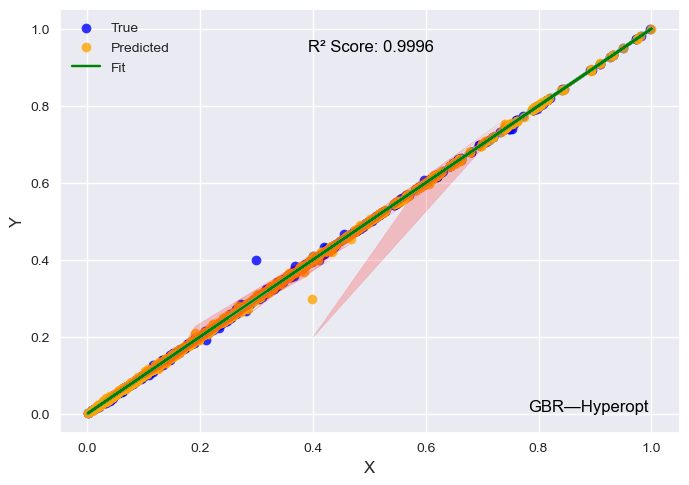

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats


# 计算R²评分
r2 = r2_score(y_test, y_pred)

# 计算拟合直线
slope, intercept, _, _, _ = stats.linregress(y_test, y_pred)
fit_line = intercept + slope * y_test

# 绘制图表
sns.set_style('darkgrid')
sns.regplot(x=y_pred, y=y_test, label='True', scatter_kws={'color': 'blue'})
sns.regplot(x=y_test, y=y_pred, label='Predicted', scatter_kws={'color': 'orange'})
plt.plot(y_test, fit_line, label='Fit', color='green')
plt.fill_between(y_test, y_pred - (y_pred - y_test), y_pred + (y_pred - y_test), alpha=0.2, color='red')
# plt.title(f'R² Score: {r2:.4f}', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.legend()
plt.text(0.95, 0.05, 'GBR—Hyperopt', transform=plt.gca().transAxes, ha='right', color='black')
# 添加文本
plt.text(0.4, 0.9, f'R² Score: {r2:.4f}', transform=plt.gca().transAxes, ha='left', color='black')
plt.show()